In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
import numpy.ma as ma
import math

In [2]:
# Connect with DASK CLUSTER created by PANGEO
from dask.distributed import Client,LocalCluster
client = Client(scheduler_file='../scheduler.json')
client

<Client: 'tcp://10.6.59.66:8734' processes=32 threads=32, memory=128.00 GiB>

In [3]:
! ls /g/data/dt55/jm1356/data/

T09_pix.csv	  T15_pix.csv	    T15_pix_mean_JP.nc	T21_pix_mean.csv
T09_pix_mean.csv  T15_pix_JP.nc     T215_pix.csv	domdata
T15_mean_JP.nc	  T15_pix_mean.csv  T21_pix.csv


In [4]:
df=pd.read_csv('/g/data/dt55/jm1356/data/T09_pix.csv',parse_dates=True)
df

Unnamed: 0                    0
0              0  2020-01-04 02:00:00
1              1  2020-01-04 03:00:00
2              2  2020-01-04 04:00:00
3              3  2020-01-04 05:00:00
4              4  2020-01-04 06:00:00
...          ...                  ...
1423        1423  2020-12-31 19:00:00
1424        1424  2020-12-31 20:00:00
1425        1425  2020-12-31 21:00:00
1426        1426  2020-12-31 22:00:00
1427        1427  2020-12-31 23:00:00

[1428 rows x 2 columns]

In [5]:
# startd = "2020-01-01T00:00"
# endd = "2020-12-31T23:00"
# freq = '10T'
# files_date = pd.date_range(startd, endd, freq=freq, closed='right')
# sample_data = '/g/data/dt55/rainfields/prcp-m60/310'
# full_list_files = sample_data + files_date.strftime("/%Y/%m/%d/*%Y%m%d_%H%M00*.nc")

In [6]:
files_date = pd.to_datetime(df.iloc[:,1])
sample_data = '/g/data/dt55/rainfields/prcp-m60/310'
full_list_files = sample_data + files_date.dt.strftime("/%Y/%m/%d/*%Y%m%d_%H%M00*.nc")

In [7]:

###
my_files = []
for fn in full_list_files:
    fn = glob.glob(fn)
    if fn:
        my_files.append(fn[0])

In [8]:
len(my_files)

1428

In [9]:
def preprocess_radar(ds):
    if 'valid_time' not in ds.coords:
        ds = ds.assign_coords(
            valid_time=ds.valid_time).expand_dims('valid_time')
    return ds

In [10]:
# open input netcdf
input_radar_ds = xr.open_mfdataset(
    my_files,
    combine='nested',
    concat_dim='valid_time',
    parallel=True,
    lock=False,
    preprocess=preprocess_radar)

In [11]:
input_radar_ds

<xarray.Dataset>
Dimensions:        (valid_time: 1428, y: 2050, n2: 2, x: 2450)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 2020-01-04T02:00:00 ... 2020-1...
  * y              (y) float64 -1.001e+03 -1.003e+03 ... -5.097e+03 -5.099e+03
  * x              (x) float64 -2.299e+03 -2.297e+03 ... 2.597e+03 2.599e+03
Dimensions without coordinates: n2
Data variables:
    start_time     (valid_time) datetime64[ns] 2020-01-04T01:00:00 ... 2020-1...
    proj           (valid_time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    y_bounds       (y, n2, valid_time) float64 dask.array<chunksize=(2050, 2, 1), meta=np.ndarray>
    x_bounds       (x, n2, valid_time) float64 dask.array<chunksize=(2450, 2, 1), meta=np.ndarray>
    precipitation  (y, x, valid_time) float32 dask.array<chunksize=(2050, 2450, 1), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.7
    contributing_sites:  [ 2  3  4  5  6  8  9 14 15 16 17 19 22 23 24 25 27 ...
    institution:         Commonwealth of Australia, Bureau of Meteorology (AB...
    licence:             http://www.bom.gov.au/other/copyright.shtml
    source:              rainfields 3.1.7 drs-rainfields 2019-04-29 python_accum
    station_id:          310
    station_name:        Ausm310
    title:               Merged Gauge/Radar Accumulation Mosaic (15 min) accu...

In [12]:
## Some useful functions
# Make a Cartopy Projection Object from netcdf Proj info
def get_ccrs_from_proj(ds):
    import cartopy.crs as ccrs
    if 'proj' in ds.variables:
        try:
            return ccrs.AlbersEqualArea(central_longitude=ds.proj.attrs['longitude_of_central_meridian'],
                            central_latitude=ds.proj.attrs['latitude_of_projection_origin'],
                            false_easting=ds.proj.attrs['false_easting'],
                            false_northing=ds.proj.attrs['false_northing'],
                            standard_parallels=ds.proj.attrs['standard_parallel'],
                            globe=None)
        except Exception as err:
            print(err)
            return ccrs.PlateCarree()


# define color table for RF3
class cmap_rf3(object):
    """Define color maps for RF3 rainfall products."""

    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    # RAINFALL
    rainfall_colors = np.array([(255, 255, 255),  # 0.0
                                (245, 245, 255),  # 0.2
                                (180, 180, 255),  # 0.5
                                (120, 120, 255),  # 1.5
                                (20,  20, 255),  # 2.5
                                (0, 216, 195),  # 4.0
                                (0, 150, 144),  # 6.0
                                (0, 102, 102),  # 10
                                (255, 255,   0),  # 15
                                (255, 200,   0),  # 20
                                (255, 150,   0),  # 30
                                (255, 100,   0),  # 40
                                (255,   0,   0),  # 50
                                (200,   0,   0),  # 60
                                (120,   0,   0),  # 75
                                (100,   0,   0)])  # > 100
    rainfall_colors = rainfall_colors/255.
    #cm_rainfall = 'blues'
    cm_rainfall = ListedColormap(rainfall_colors, 'blues')
    rainfall_levels = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_hr = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_10min = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]  
    rainfall_levels_m = [0,20,40,60,80,100,120,140,160,180,200,220,240,260]
        
def transform_coords_from_km_to_m(ds):
    """Transform coords from km to m (if required)."""
    if ds is not None:
        if 'x' in ds.coords:
            if 'units' in ds.x.attrs:
                if ds.x.units == 'km':
                    ds['x'] = ds.x*1000.
                    ds.x.attrs.update({'units': 'm'})
                    ds.x.attrs.update(
                        {'standard_name':
                         'projection_x_coordinate'})
                    message = '; Original coords x transformed to m from km'
                    if 'history' in ds.attrs:
                        ds.attrs['history'] += message
                    else:
                        ds.attrs['history'] = message
                if ds.y.units == 'km':
                    ds['y'] = ds.y*1000.
                    ds.y.attrs.update({'units': 'm'})
                    ds.y.attrs.update(
                        {'standard_name':
                         'projection_y_coordinate'})
                    ds.attrs['history'] += '; Original coords y transformed to m from km'
    return ds

def preprocess_radar(ds):
    ds = transform_coords_from_km_to_m(ds)
    if 'n2' in ds.dims:
        ds = ds.drop_dims('n2')
    return ds

def get_projection_from_dataset(rainfall):
    """Return a cartopy projection object from a dataset."""
    try:
        if ('proj' in rainfall.data_vars):
            proj = rainfall.variables['proj']
            if (proj.attrs['grid_mapping_name'] ==
                    "albers_conical_equal_area"):
                projection = ccrs.AlbersEqualArea(
                    central_longitude=proj.attrs['longitude_of_central_meridian'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    standard_parallels=proj.attrs['standard_parallel'],
                    )
            elif (getattr(proj, 'grid_mapping_name') ==
                    "gnomonic"):
                print('Projection is gnomonic')
                projection = ccrs.Gnomonic(
                    central_longitude=proj.attrs['longitude_of_projection_origin'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    )
        else:
            print("INFO: Assuming standard PlateCarree projection")
            projection = ccrs.PlateCarree()
        return projection
    except Exception as err:
        print(err)
        return None

def get_coords_from_dataset(rainfall):
    """Return coordinates in a dataset."""
    try:
        if ('lat' in rainfall.coords):
            x = rainfall['lon'][:].data
            y = rainfall['lat'][:].data
        elif ('x' in rainfall.coords):
            x = rainfall['x'][:].data
            y = rainfall['y'][:].data
            if (rainfall['x'].units == 'km'):
                factor = 1000.
                x = x * factor
                y = y * factor
        else:
            x = np.array(None)
            y = np.array(None)
        return x, y
    except Exception as err:
        print(err)
        return None, None

In [13]:
radar_data=transform_coords_from_km_to_m(input_radar_ds)
radar_data

<xarray.Dataset>
Dimensions:        (valid_time: 1428, y: 2050, n2: 2, x: 2450)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 2020-01-04T02:00:00 ... 2020-1...
  * y              (y) float64 -1.001e+06 -1.003e+06 ... -5.097e+06 -5.099e+06
  * x              (x) float64 -2.299e+06 -2.297e+06 ... 2.597e+06 2.599e+06
Dimensions without coordinates: n2
Data variables:
    start_time     (valid_time) datetime64[ns] 2020-01-04T01:00:00 ... 2020-1...
    proj           (valid_time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    y_bounds       (y, n2, valid_time) float64 dask.array<chunksize=(2050, 2, 1), meta=np.ndarray>
    x_bounds       (x, n2, valid_time) float64 dask.array<chunksize=(2450, 2, 1), meta=np.ndarray>
    precipitation  (y, x, valid_time) float32 dask.array<chunksize=(2050, 2450, 1), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.7
    contributing_sites:  [ 2  3  4  5  6  8  9 14 15 16 17 19 22 23 24 25 27 ...
    institution:         Commonwealth of Australia, Bureau of Meteorology (AB...
    licence:             http://www.bom.gov.au/other/copyright.shtml
    source:              rainfields 3.1.7 drs-rainfields 2019-04-29 python_accum
    station_id:          310
    station_name:        Ausm310
    title:               Merged Gauge/Radar Accumulation Mosaic (15 min) accu...
    history:             ; Original coords x transformed to m from km; Origin...

In [14]:
T15_file='/g/data/dt55/pst/projection/PST_tile_T15-Brisbane_projection.nc'
# T15_file='/g/data/dt55/pst/projection/PST_tile_T09-Cairns_projection.nc'
T15_tile_ds=xr.open_dataset(T15_file)
T15_tile_ds

<xarray.Dataset>
Dimensions:        (y: 512, x: 512)
Coordinates:
  * y              (y) float64 -3.411e+06 -3.409e+06 ... -2.391e+06 -2.389e+06
  * x              (x) float64 1.489e+06 1.491e+06 ... 2.509e+06 2.511e+06
Data variables:
    precipitation  (y, x) float32 ...
    proj           object ...
Attributes:
    title:    T15-Brisbane

In [15]:
_, T15_fix = xr.align(T15_tile_ds,radar_data,join='left',)

/home/548/cxv548/miniconda3/envs/pangeo_xs_mpi/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [16]:
T15_fix = T15_fix.where(T15_fix.precipitation >=0)

## CHECK THE `min_count=1`

In [17]:
T15_acc_raw=T15_fix.sum(['valid_time'],min_count=1).compute()
T15_acc_raw

<xarray.Dataset>
Dimensions:        (y: 512, x: 512, n2: 2)
Coordinates:
  * y              (y) float64 -3.411e+06 -3.409e+06 ... -2.391e+06 -2.389e+06
  * x              (x) float64 1.489e+06 1.491e+06 ... 2.509e+06 2.511e+06
Dimensions without coordinates: n2
Data variables:
    proj           (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    y_bounds       (y, n2, x) float64 nan nan nan nan nan ... nan nan nan nan
    x_bounds       (x, n2, y) float64 nan nan nan nan nan ... nan nan nan nan
    precipitation  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [18]:
T15_acc_raw.precipitation.plot(robust=True,vmin=0)

# interpolate topo to T15 projection

In [19]:
dem=xr.open_mfdataset('/g/data/dt55/wil_outputs/dem_aus.nc',parallel=True,lock=False).rename_vars({'ASCIITo_asc1':'dem'})
dem

<xarray.Dataset>
Dimensions:  (lon: 16440, lat: 13897)
Coordinates:
  * lon      (lon) float64 112.9 112.9 112.9 112.9 ... 154.0 154.0 154.0 154.0
  * lat      (lat) float64 -9.001 -9.004 -9.006 -9.009 ... -43.74 -43.74 -43.74
Data variables:
    dem      (lat, lon) float32 dask.array<chunksize=(13897, 16440), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    Source_Software:  Esri ArcGIS

In [20]:
target_proj = get_projection_from_dataset(T15_fix)
target_x_points, target_y_points = get_coords_from_dataset(T15_fix)
coord_x_grid_target, coord_y_grid_target = np.meshgrid(target_x_points,
                                                           target_y_points)
# proj_info = T15_fix.proj.copy()

In [21]:
source_proj = get_projection_from_dataset(dem)
target_xyz = source_proj.transform_points(target_proj,
                                          coord_x_grid_target,
                                          coord_y_grid_target,
                                          )
# store new coordinates in the source projection
# as DataArray

new_y = xr.DataArray(target_xyz[:, :, 1],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})
new_x = xr.DataArray(target_xyz[:, :, 0],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})

INFO: Assuming standard PlateCarree projection


In [22]:
topo = dem.dem.interp(lon=new_x,lat=new_y,method='nearest').load()
topo

/home/548/cxv548/miniconda3/envs/pangeo_xs_mpi/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'dem' (y: 512, x: 512)>
array([[130.9177, 129.6372, 131.3222, ...,      nan,      nan,      nan],
       [129.4166, 129.1275, 131.1283, ...,      nan,      nan,      nan],
       [127.5058, 128.5936, 129.    , ...,      nan,      nan,      nan],
       ...,
       [257.3539, 289.2028, 315.1476, ...,      nan,      nan,      nan],
       [266.2537, 273.8461, 299.9976, ...,      nan,      nan,      nan],
       [273.1362, 258.1303, 266.5166, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
    lon      (y, x) float64 147.7 147.7 147.8 147.8 ... 156.2 156.2 156.2 156.3
    lat      (y, x) float64 -30.5 -30.5 -30.49 -30.49 ... -20.06 -20.06 -20.05
  * x        (x) float64 1.489e+06 1.491e+06 1.493e+06 ... 2.509e+06 2.511e+06
  * y        (y) float64 -3.411e+06 -3.409e+06 ... -2.391e+06 -2.389e+06
Attributes:
    long_name:       ASCIITo_asc1
    esri_pe_string:  GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1...
    units:           Degree

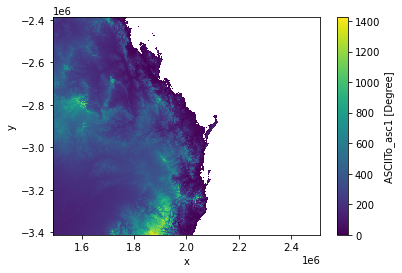

In [23]:
topo.drop(['lat','lon']).plot()

In [24]:
topo_levels = [0,200,400,600,800,1000]
topo_plot=topo.drop(['lat','lon'])

Text(0.5, 1.0, 'Brisbane Precipitation Accumulation - 2020')

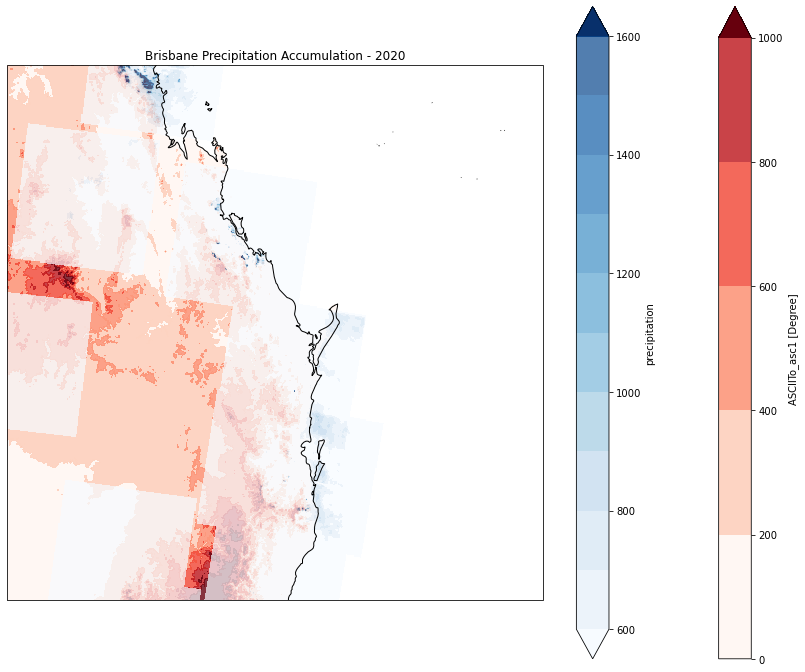

In [25]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj})
topo_plot.plot.contourf(levels=topo_levels,cmap='Reds',add_colorbar=True,ax=ax,add_labels=True,alpha=0.8)
T15_acc_raw.precipitation.plot(ax=ax,add_colorbar=True,cmap='Blues',
            levels=cmap_rf3.rainfall_levels_hr,alpha=0.7)
ax.coastlines('10m')
ax.set_title('Brisbane Precipitation Accumulation - 2020')

In [26]:
T15_full_topo= T15_acc_raw.assign(dem=topo.drop(['lat','lon']))
T15_full_topo

<xarray.Dataset>
Dimensions:        (y: 512, x: 512, n2: 2)
Coordinates:
  * y              (y) float64 -3.411e+06 -3.409e+06 ... -2.391e+06 -2.389e+06
  * x              (x) float64 1.489e+06 1.491e+06 ... 2.509e+06 2.511e+06
Dimensions without coordinates: n2
Data variables:
    proj           (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    y_bounds       (y, n2, x) float64 nan nan nan nan nan ... nan nan nan nan
    x_bounds       (x, n2, y) float64 nan nan nan nan nan ... nan nan nan nan
    precipitation  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dem            (y, x) float32 130.9 129.6 131.3 129.5 ... nan nan nan nan

In [27]:
#calculate mean precipitation per elevation bins
elevation_bins=np.append(-1000, np.arange(0, 1600, 50))
label_bins=np.append([0], np.arange(25,1550, 50))


In [28]:
elevation_bins

array([-1000,     0,    50,   100,   150,   200,   250,   300,   350,
         400,   450,   500,   550,   600,   650,   700,   750,   800,
         850,   900,   950,  1000,  1050,  1100,  1150,  1200,  1250,
        1300,  1350,  1400,  1450,  1500,  1550])

In [29]:
label_bins

array([   0,   25,   75,  125,  175,  225,  275,  325,  375,  425,  475,
        525,  575,  625,  675,  725,  775,  825,  875,  925,  975, 1025,
       1075, 1125, 1175, 1225, 1275, 1325, 1375, 1425, 1475, 1525])

In [30]:
mean_precip_per_bin = T15_full_topo.drop(['y_bounds','x_bounds']).groupby_bins("dem",elevation_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation
mean_precip_per_bin

<xarray.DataArray 'precipitation' (dem_bins: 32)>
array([499.9699 , 388.41248, 347.3917 , 299.73077, 239.41522, 296.18857,
       306.64932, 304.8541 , 286.0452 , 271.17502, 254.3364 , 251.41425,
       251.29369, 241.54639, 246.73595, 266.11285, 266.9109 , 251.91444,
       238.75679, 225.96298, 229.95195, 224.13159, 240.82317, 245.1    ,
       236.97334, 229.32759, 223.45714, 195.24063, 176.59062, 160.16667,
             nan,       nan], dtype=float32)
Coordinates:
  * dem_bins  (dem_bins) int64 0 25 75 125 175 225 ... 1325 1375 1425 1475 1525

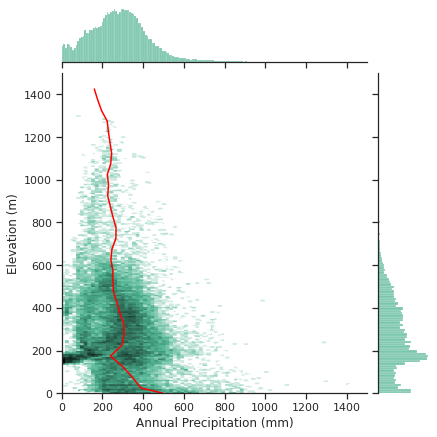

In [31]:
import seaborn as sns
sns.set_theme(style="ticks")

y = T15_full_topo.dem.data.ravel()
x = T15_full_topo.precipitation.data.ravel()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,1500),ylim=(0,1500),gridsize=(200,200),hue_norm=(0,10),bins='log')
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Annual Precipitation (mm)')
plt.plot(mean_precip_per_bin,mean_precip_per_bin.dem_bins,color='red')

plt.show()

In [32]:
# repeat the same plots but using the MEAN and STD of hourly rainfall


In [33]:
# MEAN
T15_acc_mean=T15_fix.mean(['valid_time'],).compute()


In [34]:
T15_acc_mean.precipitation.plot(robust=True)

In [35]:
T15_full_mean_topo= T15_acc_mean.assign(dem=topo.drop(['lat','lon']))
T15_full_mean_topo

<xarray.Dataset>
Dimensions:        (y: 512, x: 512, n2: 2)
Coordinates:
  * y              (y) float64 -3.411e+06 -3.409e+06 ... -2.391e+06 -2.389e+06
  * x              (x) float64 1.489e+06 1.491e+06 ... 2.509e+06 2.511e+06
Dimensions without coordinates: n2
Data variables:
    proj           (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    y_bounds       (y, n2, x) float64 nan nan nan nan nan ... nan nan nan nan
    x_bounds       (x, n2, y) float64 nan nan nan nan nan ... nan nan nan nan
    precipitation  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dem            (y, x) float32 130.9 129.6 131.3 129.5 ... nan nan nan nan

In [36]:
mean_mean_precip_per_bin = T15_full_mean_topo.drop(['y_bounds','x_bounds']).groupby_bins("dem",elevation_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation
mean_mean_precip_per_bin

<xarray.DataArray 'precipitation' (dem_bins: 32)>
array([0.3501716 , 0.27207312, 0.24343123, 0.21039678, 0.16912581,
       0.20913003, 0.21607123, 0.21492149, 0.20275576, 0.1922302 ,
       0.18049216, 0.17832975, 0.17807026, 0.17126046, 0.17471424,
       0.1879941 , 0.18776911, 0.1769137 , 0.16753852, 0.15845822,
       0.16125228, 0.15712075, 0.1689128 , 0.17190722, 0.1661235 ,
       0.16059355, 0.15648259, 0.13672313, 0.12366291, 0.11216154,
              nan,        nan], dtype=float32)
Coordinates:
  * dem_bins  (dem_bins) int64 0 25 75 125 175 225 ... 1325 1375 1425 1475 1525

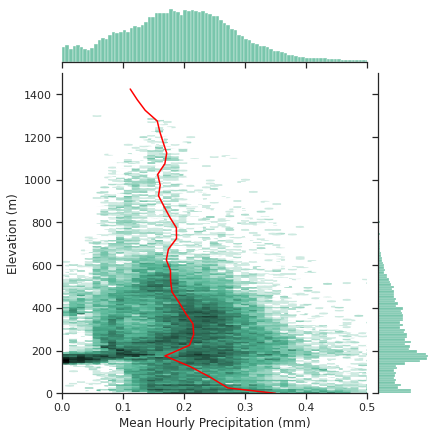

In [37]:
import seaborn as sns
sns.set_theme(style="ticks")

y = T15_full_mean_topo.dem.data.ravel()
x = T15_full_mean_topo.precipitation.data.ravel()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,0.5),ylim=(0,1500),gridsize=(200,200),bins='log')
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Mean Hourly Precipitation (mm)')
plt.plot(mean_mean_precip_per_bin,mean_precip_per_bin.dem_bins,color='red')

plt.show()

In [38]:
#STD DEV
# T15_acc_std=T15_fix.std(['valid_time']).compute()
# 

In [39]:
# mean_std_precip_per_bin = T15_full_std_topo.drop(['y_bounds','x_bounds']).groupby_bins("dem",elevation_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation
# mean_std_precip_per_bin

In [40]:
# T15_acc_std.precipitation.plot(robust=True)

In [41]:
# T15_full_std_topo= T15_acc_std.assign(dem=topo.drop(['lat','lon']))
# T15_full_std_topo

In [42]:
# import seaborn as sns
# sns.set_theme(style="ticks")

# y = T15_full_std_topo.dem.data.ravel()
# x = T15_full_std_topo.precipitation.data.ravel()

# plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,5),ylim=(0,1500),gridsize=(200,200),bins='log')
# plot.ax_joint.set_ylabel('Elevation (m)')
# plot.ax_joint.set_xlabel('Standard Dev Hourly Precipitation (mm)')
# plt.plot(mean_std_precip_per_bin,mean_precip_per_bin.dem_bins,color='red')

# plt.show()

In [43]:
hour=5
T15_fix_hour=T15_fix.isel(valid_time=T15_fix.valid_time.dt.hour.isin([hour]))
T15_fix_hour_mean = T15_fix_hour.mean(['valid_time'],).compute()
T15_fix_hour_mean_topo= T15_fix_hour_mean.assign(dem=topo.drop(['lat','lon']))
mean_mean_precip_hour_per_bin = T15_fix_hour_mean_topo.drop(['y_bounds','x_bounds']).groupby_bins("dem",elevation_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation


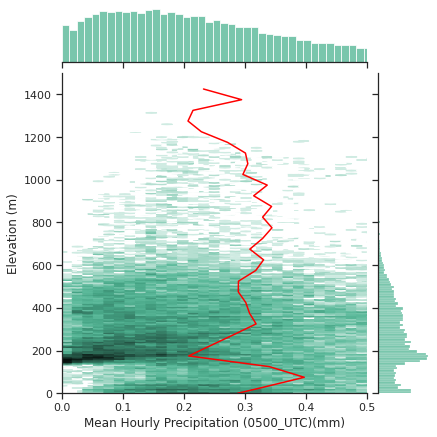

In [44]:
import seaborn as sns
sns.set_theme(style="ticks")

y = T15_fix_hour_mean_topo.dem.data.ravel()
x = T15_fix_hour_mean_topo.precipitation.data.ravel()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,0.50),ylim=(0,1500),gridsize=(200,200),bins='log')
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Mean Hourly Precipitation (0500_UTC)(mm)')
plt.plot(mean_mean_precip_hour_per_bin,mean_mean_precip_hour_per_bin.dem_bins,color='red')

plt.show()